<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/4_DiffusionEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
%pip install pyDOE


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [4]:
steps=20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000

# Auxiliary Functions


In [5]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [6]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

# Problem Setup
https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html

**Diffusion equation**

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

### Initial Condition:

$$y(x,0)=sin(\pi x)$$

### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

### Exact solution:

$$y(x,t)=e^{-t}sin(\pi x)$$

# Analysis:
## PDE
$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

If we rearrange our PDE, we get:

$$\left(\frac{\partial y}{\partial t} -\frac{\partial^2 y}{\partial x^2}\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))=0$$

## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset(known data).
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$NN(x,t)\approx y(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\frac{\partial^2 NN}{\partial x^2}$.(Automatic Diferentiation) 

Assume:$$NN(t,x)\approx y(t,x)$$ 

Then:

$$\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))\approx \left(\frac{\partial y}{\partial t} -\frac{\partial^2 y}{\partial x^2}\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))=0$$

And:

$$\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))\approx 0$$


We define this function as $f$:

$$f(t,x)=\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

If $f\rightarrow 0$ then our NN would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_f$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

#### Initial Condition:

$$y(x,0)=sin(\pi x)$$

#### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN(t_{u}^i,x_u^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

## Functions

In [7]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x)) #Defines the exact solution: freal(x,t)

### Neural Network

In [8]:
class FCN(nn.Module):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    ##Neural Network
    """
    Summary

    Superclass Initialization: Ensures the base class nn.Module is properly initialized.
    Activation Function: Uses Tanh to introduce non-linearity.
    Loss Function: Uses MSE loss to measure the error.
    Layer Initialization: Creates a sequence of linear layers based on the provided layers list.
    Optimizer Iteration Counter: Keeps track of the number of iterations for the optimizer.
    Xavier Initialization: Properly initializes weights and biases to aid in training convergence.

This __init__ method sets up the neural network architecture and prepares it for training by initializing all necessary components and parameters.
    """
    def __init__(self,layers):#Constructor method that initializes the neural network with the given layers.
        super().__init__() #call __init__ from parent class Calls the constructor of the parent class (nn.Module). This is necessary to properly initialize the base class part of the FCN objec
        'activation function'
        self.activation = nn.Tanh() #This activation function is applied to the outputs of each layer, introducing non-linearity into the model.
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean') #The Mean Squared Error (MSE) loss is used here, which is common for regression tasks.ff
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) #Initializes a list of linear layers using nn.ModuleList. Each linear layer is fully connected, defined by the nn.Linear class, and connects layer i to layer i+1. The number of layers and their sizes are defined by the layers list provided to the constructor.
        self.iter = 0 #For the Optimizer.  Initializes an iteration counter to be used by the optimizer.
        'Xavier Normal Initialization. Initializes the weights of the linear layers using the Xavier normal initialization method. This method helps in maintaining the variance of weights throughout the network, which can help in faster convergence'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #nitializes the weights of the i-th linear layer using Xavier normal initialization. The gain parameter is set to 1.0, which is the recommended value for the Tanh activation function.
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) #Initializes the biases of the i-th linear layer to zero.

            """
            The forward method defines the forward pass of the neural network, which is how input data passes through the network to produce an output.
            Summary

    Input Handling: Converts input data to a PyTorch tensor if it is not already one and ensures it is of float type.
    Layer Processing: Passes the input through each layer, applying the linear transformation followed by the activation function, except for the final layer where only the linear transformation is applied.
    Output: Produces and returns the final output of the network.
            """   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x) #If x is not a tensor (likely a NumPy array), it converts x to a PyTorch tensor using torch.from_numpy               
        a = x.float()
        for i in range(len(layers)-2): #Loops through all but the last layer in the list of linear layers (self.linears).  
            z = self.linears[i](a) # Applies the i-th linear layer to the input a, producing the output z.             
            a = self.activation(z) #Applies the activation function (Tanh) to the output z, producing the activated output a. This introduces non-linearity into the network.   
        a = self.linears[-1](a) #Applies the last linear layer (output layer) to the activated output a. Note that the activation function is not applied to the output layer, typically because the final output might not require non-linearity, especially in regression tasks.
        return a
    
    """
    Summary

    lossBC Method:
        Computes the mean squared error between the network's predictions and the target values for the boundary conditions.

    lossPDE Method:
        Computes the mean squared error for the PDE residual. This involves calculating the first and second derivatives of the network's output with respect to the input points and ensuring the network satisfies the PDE.

    loss Method:
        Combines the boundary condition loss and the PDE loss to compute the total loss, which guides the training of the neural network to respect both the boundary conditions and the PDE.
    """
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):#Computes the loss for the boundary conditions (BC).
      loss_BC=self.loss_function(self.forward(x_BC),y_BC) #self.forward(x_BC): Passes the boundary input points through the network to get predictions. self.loss_function(self.forward(x_BC), y_BC): Computes the mean squared error between the network's predictions and the target boundary values.
      return loss_BC #Returns the boundary condition loss (loss_BC).
    #Loss PDE
    def lossPDE(self,x_PDE): #x_PDE: The input data points for evaluating the PDE.
      g=x_PDE.clone() #Clones the input points to avoid modifying the original data.
      g.requires_grad=True #Enable differentiation
      f=self.forward(g) #Passes the cloned input points through the network to get predictions.
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #Computes the first derivative of the network's output with respect to g.
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#Computes the second derivative of the network's output with respect to g.
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) Selects the derivative with respect to time (t)
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) Selects the second derivative with respect to space (x).
      f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))#The final f expression represents the residual of the PDE. It is the difference between the first derivative with respect to time and the second derivative with respect to space, plus the exact solution of the PDE.
      return self.loss_function(f,f_hat) # Computes the mean squared error between the residual and the target values (f_hat), which are typically zeros

    'Computes the total loss by combining the boundary condition loss and the PDE loss. The total loss guides the training of the neural network to respect both the boundary conditions and the PDE.'
    def loss(self,x_BC,y_BC,x_PDE): # The input data points at the boundary. y_BC: The target values at the boundary. x_PDE: The input data points for evaluating the PDE.
      loss_bc=self.lossBC(x_BC,y_BC) #Computes the boundary condition loss.
      loss_pde=self.lossPDE(x_PDE) #Computes the PDE loss.
      return loss_bc+loss_pde #Returns the total loss, which is the sum of the boundary condition loss and the PDE loss.

    """
    Summary#

    optimizer.zero_grad(): Clears previous gradients to prevent accumulation.
    self.loss(...): Computes the total loss using the model's loss function, which includes boundary condition and PDE losses.
    loss.backward(): Performs backpropagation to compute gradients.
    self.iter += 1: Increments the iteration counter for tracking.
    Logging and Evaluation:
        Every 100 iterations, the method computes the loss on a test set and prints both training and testing errors to monitor the progress.
    return loss: Returns the loss value, which is necessary for optimizers like L-BFGS that use closure functions.
    """

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad() #Clears old gradients from the previous step (if any). This is necessary to avoid accumulation of gradients from multiple backward passes. 
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf) #Computes the total loss by calling the loss method of the model, which combines the boundary condition loss (lossBC) and the PDE loss (lossPDE). The inputs are: X_train_Nu: The input data points at the boundary. Y_train_Nu: The target values at the boundary. X_train_Nf: The input data points for evaluating the PDE.
      loss.backward()  #Computes the gradients of the loss with respect to the model parameters. These gradients are used by the optimizer to update the model parameters.    
      self.iter += 1 #Increments the iteration counter to keep track of the number of iterations.
      if self.iter % 100 == 0: #Every 100 iterations, perform additional actions such as logging the training and testing errors.
        loss2=self.lossBC(X_test,Y_test) #Computes the boundary condition loss on the test dataset.
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy()) #Detaches the loss tensor from the computation graph and moves it to the CPU, converting it to a NumPy array for printing.
      return loss   

# Generate data

c:\SPDP\SPDPvenv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


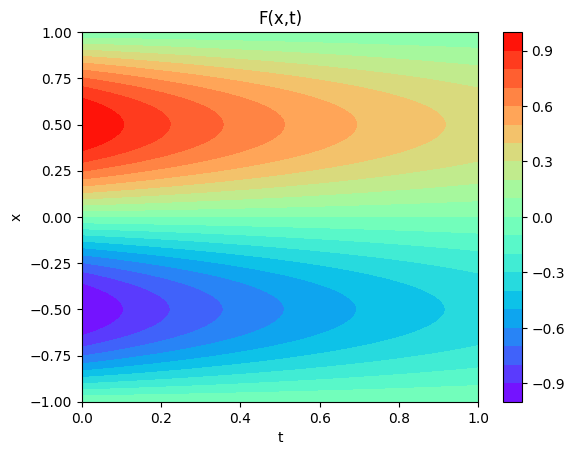

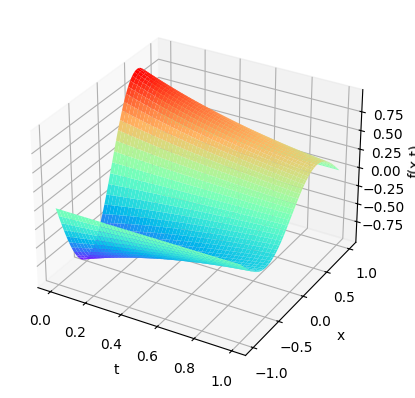

In [9]:
"""
Summary Explanation

    Vector Creation: Generate linearly spaced vectors for spatial and temporal domains.
    Mesh Grid Creation: Construct a grid of coordinates covering the entire space-time domain.
    Function Evaluation: Compute the values of the exact solution on the mesh grid.
    Visualization: Plot the 3D surface to visualize how the real function behaves over space and time.
"""

x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X,T)
plot3D(x,t,y_real) #f_real was defined previously(function)

In [10]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


## Prepare Data

In [11]:
'''
Summary Explanation

    Transformation: The mesh grid XX and TT are transformed into a 2-column vector xtestxt​est, where each row represents a point in the space-time domain.
    Domain Bounds: The lower and upper bounds of the domain are determined from the first and last values of xtestxt​est, respectively.
    Verification: Printing the shapes of xtestxt​est and ytestyt​est ensures that the transformation and flattening operations have been performed correctly.

This setup is essential for preparing data to be fed into a PINN for training and testing, ensuring that the neural network can learn the underlying physics described by the PDE across the entire domain.
'''

# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value lower bound
ub=x_test[-1] #last value upper bound
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


## Training Data

In [12]:
'''
Summary Explanation
    Initial and Boundary Conditions: Constructed to reflect the known conditions of the PDE.
    Combining Data: Integrates all the conditions into a single dataset for training.
    Random Selection and LHS Sampling: Ensures a diverse and representative set of points for training the PINN.
    Training and Collocation Points: Combined to help the network learn both the physical laws and the boundary/initial conditions effectively.
This setup prepares the necessary data for training a Physics-Informed Neural Network, ensuring it respects the given PDE and its boundary/initial conditions.
'''
#Initial Condition   Constructs the initial condition by selecting the first column of the mesh grid (where t=0t=0) and computing sin⁡(πx)sin(πx).
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)

#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max Bottom Edge: x=xmin, where y=0 for all t.
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)

#Top Edge: x=max; 0=<t=<1  Top Edge: x=xmax​, where y=0 for all t.
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)

#Get all the training data into the same dataset. Combine initial condition and boundary conditions into a single training dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])

#Nu​ Number of points from initial and boundary conditions used in training. These points help the network learn to respect the given physical constraints at the boundaries and the initial state.
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]

# Nf​ Number of collocation points used for evaluating the PDE across the domain. These points ensure the neural network solution satisfies the PDE everywhere within the domain.
#Choose(Nf) points(Latin hypercube sampling lhs)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

In [13]:
"""
"""
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([200, 100]) torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


# Train Neural Network

In [14]:
torch.manual_seed(123) #Ensures reproducibility of results by setting a fixed seed for random number generation.
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC) Training points for boundary conditions.
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC) 
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function Target residuals for the PDE, initialized to zeros.

X_test=x_test.float().to(device) # the input dataset (complete) Complete dataset for testing and real solution comparison.
Y_test=y_test.float().to(device) # the real solution Complete dataset for testing and real solution comparison.


#Create Model
PINN = FCN(layers) # PINN is the neural network model defined using the class FCN. Initializes the neural network model and transfers it to the GPU.
PINN.to(device)
print(PINN) #Printing the model to see its architecture and parameters.
params = list(PINN.parameters())  ##extracts the neural network model's parameters into a list. This is useful for initializing optimizers that will update these parameters during training.
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False) #The extracted parameters are then passed to the optimizer to set up the training process. Here, we use the Adam optimizer with a learning rate of 0.001.
'''
a commented-out section for using the L-BFGS optimizer, which is sometimes used for training neural networks due to its robustness for certain types of problems:
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time() #Begins timing the training process for performance measurement.


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
#optimizer.step(PINN.closure)

In [16]:
for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
16.872953 --- 0.21578383
0.002315789 --- 0.04003001
0.00095976033 --- 0.037161645
0.00045788076 --- 0.036339484
0.0002269193 --- 0.036198534
0.00013627353 --- 0.03616639
0.00010088846 --- 0.036122784
0.00013305798 --- 0.036306143
8.781903e-05 --- 0.036208753
7.324338e-05 --- 0.036075816


### Plots

In [17]:
y1=PINN(X_test)

In [18]:
x1=X_test[:,0]
t1=X_test[:,1]

In [19]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

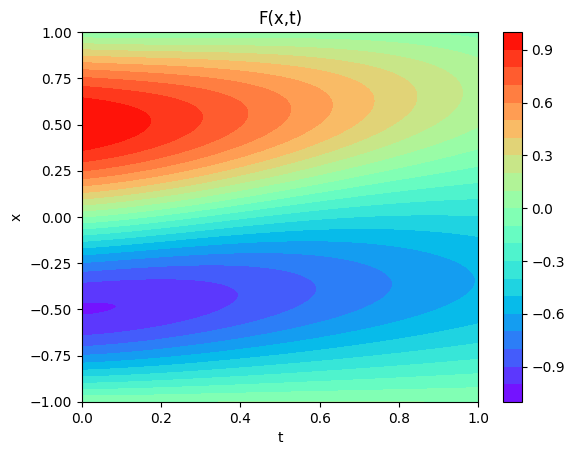

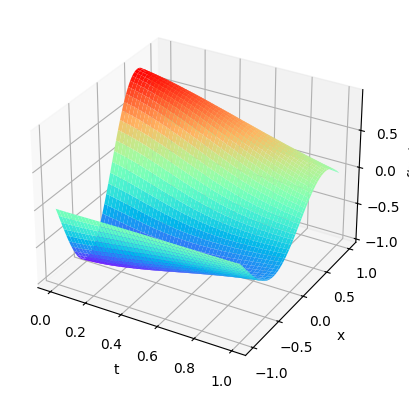

In [20]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

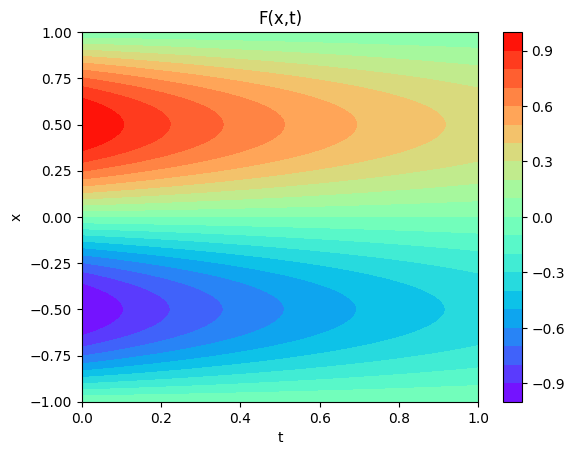

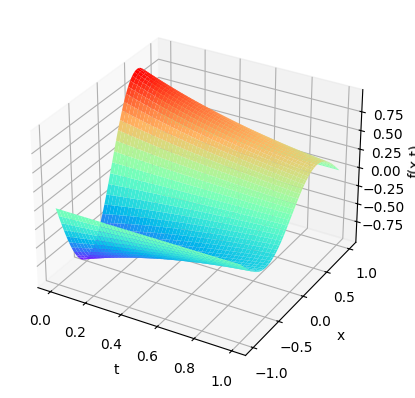

In [21]:
plot3D_Matrix(X,T,y_real)

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
